<center><h1> Self Supervised Learning</h1></center>

<div Align= 'justify'>In all of the previous classification tasks, we had a high amount of labeled images for each classes. This allows our model to properly learn and generally achieve good accuracy given enough images. However, we often **don't have access** to a high amount of labeled data; but only a **small set of labeled data** and a bigger set of unlabeled data.

Therefore, we would be interested in a learning strategy that would enable us to **extract useful information from the unlabeled image** set for a simpler representations (Representation Learning) and then use the labeled samples to learn a classifier on these representations (Fine-tunning Classification). One simple yet successful approach has been the use of pretext tasks. **Pretext tasks** learning consists in considering an **auxiliary task**, different from our target task, and learn a network by solving this task. Then, we only keep part of the network as a representation encoder. The full process is summarized bellow: </div>


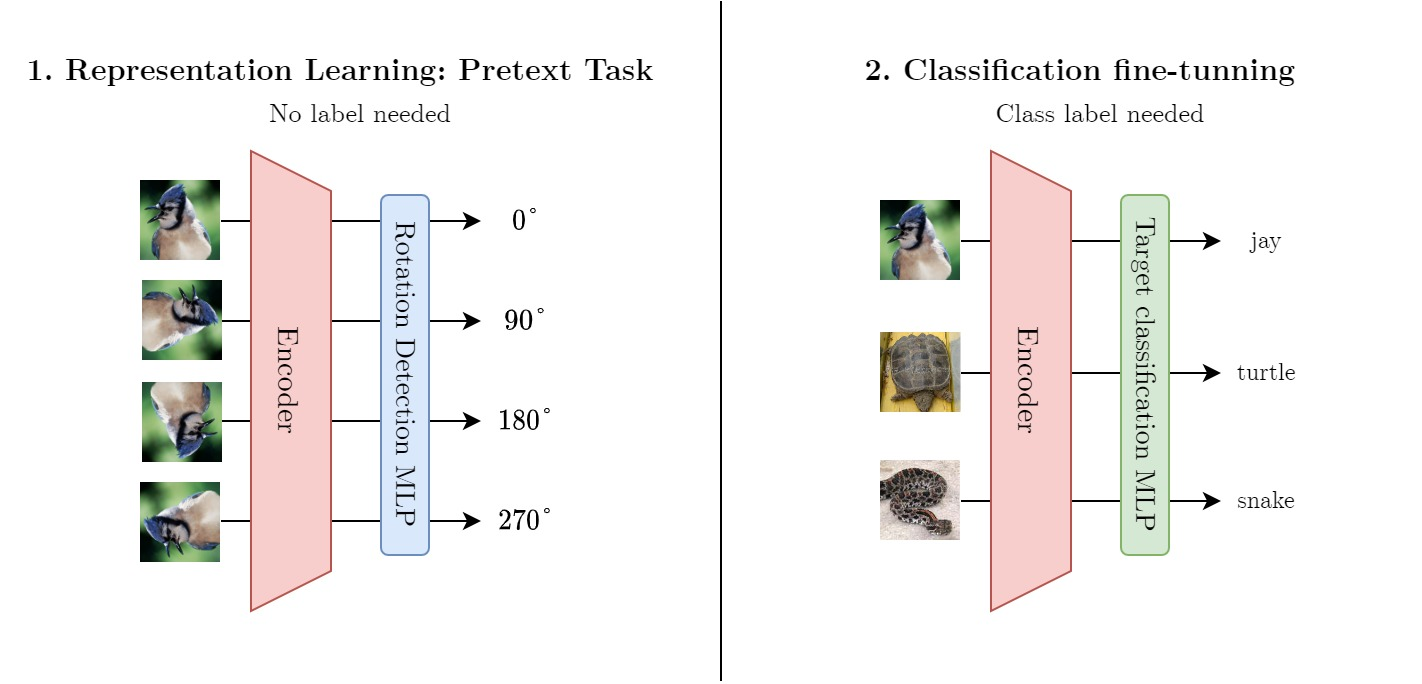


Pretext tasks are a part of self-supervised learning methods that formulate a supervised learning scheme from unlabeled data.


**Goal of this lab** :
* Understand how representation learning through pretext tasks works
* Practice fine-tuning
* Overview some other applications of pretext tasks
* Reuse Pytorch Lightning

# 0 - Preparation

In [1]:
%%capture
!pip install pytorch-lightning
!pip install wandb

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import torchmetrics
import torchvision.transforms as transforms
import os
import glob
import cv2
from torch.utils.data import Dataset, Subset, DataLoader
import random
import torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(42)
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10
from torchvision.datasets import SVHN as torch_SVHN
from torchvision.models import resnet18, resnet50
from torchvision.datasets.utils import extract_archive
from pytorch_lightning.loggers import WandbLogger
import cv2 as cv

import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer

USE_COLAB = True
CONTENT_DIR = "/content" if USE_COLAB else "."

def imshow(img):
    if isinstance(img, torch.Tensor):
        img = np.moveaxis(img.detach().cpu().numpy(), 0, -1)
    plt.axis("off")
    plt.imshow(img)
    plt.show()

**Logging with Wandb**

<div Align='justify'>For all the training in this lab, we will be using 'Weights & Biases' (w&b) as the logger. WandB is used in lots of companies as it provides a hassle free logging interface. It is generally more powerful and convenient to use than Tensorboard. As Tensorboard, WandB is also deployable in productions. In our case, we will use the cloud version hosted by WandB. In all of these experiments, our experiments will be logged and sent to a specific link which will be provided by WandB.</div>

```python
logger = WandbLogger(...)
```

Provide <a href="https://wandb.ai/authorize" target="_blank" rel="noopener noreferrer">your API key</a> when prompted.

In [3]:
import wandb
if not wandb.login():
    raise ValueError("WandDB authentification failed.")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# I - Industrial Task 1 : Classifying street number with few labeled data

<div Align="justify">Let imagine that you want to recognize street numbers from street view imagery. Since you have free access to many street photos containing street numbers, you can obtain a huge amount of pictures of street numbers (let put aside how you extract and isolate them from full street images). However, you don't have the label (number) information for each of these images. Consequently, you painstakingly go over the first 1000 images and manually label them. Tools like LabelImg, CVAT are your best friends for a while..</div>


<div Align="justify">You are in a semi-supervised setting where you have access to a high amount of street number images but only 1% of labeled data.

In this first part you will evaluate **how pretext tasks can be applied to help you leverage the informations in the unlabeled set to achieve good classification performances.** </div>

## 1 - Street View House Numbers

To reproduce the aformentionned scenario, we will be using the Street View House Numbers (SVHN) dataset, and remove 99% of the labels of the training data.

In [4]:
class SVHN(Dataset):
    def __init__(self, root, split, download=True, label_p=0.01, **kwargs):
        if split == "test":
            self.keep_label = True
            self.base_dt = torch_SVHN(root, split='test', download=download, **kwargs)
        elif split in ["train_labeled", "train_unlabeled"]:
            dt_train = torch_SVHN(root, split='train', download=download, **kwargs)
            labeled_size = int(label_p * len(dt_train))
            unlabeled_size = len(dt_train) - labeled_size
            torch.manual_seed(42)
            dt_train_unlabeled, dt_train_labeled = torch.utils.data.random_split(
                dt_train, [unlabeled_size, labeled_size]
            )
            if split == "train_labeled":
                self.keep_label = True
                self.base_dt = dt_train_labeled
            else:  # train_unlabeled
                self.keep_label = False
                self.base_dt = dt_train_unlabeled
        else:
            raise ValueError(f"Invalid split name: {split}. Must be 'test', 'train_labeled', or 'train_unlabeled'.")

    def __getitem__(self, k):
        if self.keep_label:
            return self.base_dt[k]
        return self.base_dt[k][0]  # Retourne uniquement l'image si non labellisé

    def __len__(self):
        return len(self.base_dt)

First of all, perform an Exploratory Data Analysis (EDA) on the SVHN Dataset :

1.   What type of Data do you have ? (Images, Texts, Sound..)
2.   How many Data do you have ?
3.   What's in a sample (1 element of the Dataset)
4.   Is the Dataset unbalanced ?
5.   What's the shape of any input sample ?
6.   ....


In [5]:
# Loading the Training Splits of SVHN Dataset
dataset_train  = SVHN('.', split='train_labeled', download=True) # Labeled Dataset
dataset_train_ul = SVHN('.', split='train_unlabeled', download=True) # Unlabeled Dataset



100%|██████████| 182M/182M [00:55<00:00, 3.27MB/s]


Using downloaded and verified file: ./train_32x32.mat


 size unlabeled : 732  size unlabeled : 72525
shape unlabeled (72525, 32, 32, 3)
Image de dataset_train :


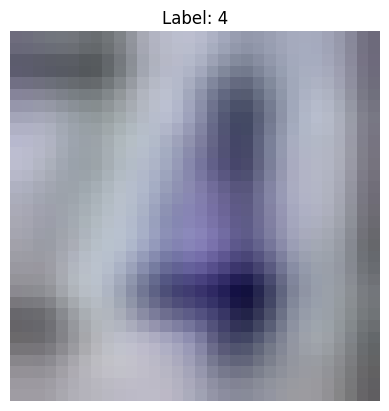

Image de dataset_train_ul :


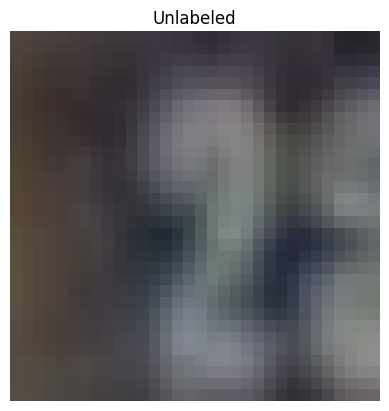

In [6]:
# TODO :
# What is the amount of labeled and unlabeled data ?
print(" size unlabeled :" ,len(dataset_train)," size unlabeled :", len(dataset_train_ul))

# What is in a sample ? Print the sample to understand
print("shape unlabeled",np.shape(dataset_train_ul))

import matplotlib.pyplot as plt

# Afficher une image de dataset_train
print("Image de dataset_train :")
image, label = next(iter(dataset_train))  # Récupérer la première image et son label
plt.imshow(image)  # Afficher l'image
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

# Afficher une image de dataset_train_ul
print("Image de dataset_train_ul :")
image = next(iter(dataset_train_ul))  # Récupérer la première image (sans label)
plt.imshow(image)  # Afficher l'image
plt.title("Unlabeled")
plt.axis("off")
plt.show()


We start by defining a datamodule for the labeled classification.

**TODO**: Using your previous knowledge of datamodule declaration, fully define a datamodule for the **labeled data** from the previously defined Dataset `SVHN` that we will try to solve the digit classification task from.
- Your LightningDataModule should implement the following methods:
* `def setup(self, stage)`
* `def train_dataloader(self)`
* `def val_dataloader(self)`
* `def test_dataloader(self)`.


The validation data should be sampled from the training data with a ratio of 25%.

In [7]:
class SVHNDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.data_dir = data_dir or "."
        self.batch_size = batch_size

    def setup(self, stage=None):
        """
        Prépare les datasets en fonction du stage spécifié :
        - 'fit': prépare les datasets d'entraînement et de validation.
        - 'test': prépare le dataset de test.
        """
        if stage == "fit" or stage is None:
            full_train_dataset = SVHN(  # Utilisation de la classe SVHN
                self.data_dir, split="train_labeled", transform=self.transform, download=True
            )
            # Diviser en 75% train et 25% validation
            train_size = int(0.75 * len(full_train_dataset))
            val_size = len(full_train_dataset) - train_size
            self.train_dataset, self.val_dataset = random_split(
                full_train_dataset, [train_size, val_size]
            )

        if stage == "test" or stage is None:
            self.test_dataset = SVHN(  # Utilisation de la classe SVHN
                self.data_dir, split="test", transform=self.transform, download=True
            )

    def train_dataloader(self):
        """Retourne le DataLoader pour l'entraînement."""
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        """Retourne le DataLoader pour la validation."""
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        """Retourne le DataLoader pour le test."""
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

## 2 - SVHN Classifier from scratch

In a first time, we will directly train a classifier on the few labeled data and evaluate its accuracy on the test set.

 **<center>You are free to design the architecture of your model.</center>**

To facilitate the next sections, we will split the model into two parts:
1. **The encoder**: the succession of conv filters. Its role is to convert our images into useful representations
2. **The classifier**: an MLP which role is to predict the label given the representations

We will be using a well-known backbone for the encoder: a resnet18.

Some advices for the choice of architecture:

For the encoder sequence of nn.Conv2D filter size of 3, and stride or maxpooling

Make sure the linear size match, you can print your input size in the forward method of your model to help or use torchsummary.

In [79]:
from torchmetrics.classification import MulticlassAccuracy

class SVHNEncoder(nn.Module):
    """
    Model encoder.
    """
    def __init__(self):
        super().__init__()
        self.backbone = resnet18()
        self.backbone.fc = nn.Identity()

    def forward(self, x):
        return self.backbone(x)


class SVHNClassifier(pl.LightningModule):
    """
    Model classifier.
    """
    def __init__(self, n_class):
        # TODO : Define your classifier model (with n_class classes) here.
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256, n_class)
        )
    def training_step(self, batch, batch_idx):
        x, y = batch
        # Pass the input through the encoder
        features = self.encoder(x)
        # Pass the features through the classifier
        logits = self.classifier(features)
        # Calculate the loss
        loss = F.cross_entropy(logits, y)
        # Log the loss
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.classifier.parameters(), lr=1e-3)
        return optimizer

    def train_dataloader(self):
        return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

    def val_dataloader(self):
        return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)



    def forward(self, x):
        # TODO : Forward x
        return self.classifier(x)



class SVHNModel(pl.LightningModule):
    """
    Full SVHN lightning module.
    """
    def __init__(self, lr=1e-1):
        super().__init__()
        self.encoder = SVHNEncoder() # TODO : Define your Encoder
        self.classifier = SVHNClassifier(n_class=10) # TODO : Define your Classifier. What is n_class ?
        self.lr = lr

        # Initialisation de la métrique avec num_classes=10
        self.accuracy = MulticlassAccuracy(num_classes=10)

    def forward(self,x):
        # TODO: Forward x
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits


    def configure_optimizers(self):
        # TODO : Define your optimizer
        optimizer = torch.optim.Adam(self.parameters(), self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        # TODO : Define your Training Step
        # This method is pretty much similar to what your did in the MNIST classification.
        # Récupérer les images et les labels du lot
        images, labels = batch

        # Propagation avant
        logits = self(images)
        loss = F.cross_entropy(logits, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # TODO : Define your Validation Step
        # Récupérer les images et les labels du lot
        images, labels = batch

        # Propagation avant
        logits = self(images)
        loss = F.cross_entropy(logits, labels)

        # Calcul de précision pour le suivi des performances
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, labels)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        # TODO : Define your Test Step
        # What is the difference between the Training, Validation and Test Step ?
        # Récupérer les images et les labels du lot
        images, labels = batch

        # Propagation avant
        logits = self(images)
        loss = F.cross_entropy(logits, labels)

        # Calcul de précision
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, labels)
        self.log('test_loss', loss)  # Log test loss



### Training

Launch the Training on the `SVHNDataModule`.

In [80]:
# TODO :
model = SVHNModel(lr=1e-3)
dm = SVHNDataModule(".", batch_size = 32)
logger=WandbLogger(name='SVHN_scratch',project='SVHN_classif')

trainer = pl.Trainer(devices='auto',
                     max_epochs=10,
                     accelerator='gpu',
                     default_root_dir="SVHN_classification",
                     logger=logger)

trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Using downloaded and verified file: ./train_32x32.mat


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | SVHNEncoder        | 11.2 M | train
1 | classifier | SVHNClassifier     | 133 K  | train
2 | accuracy   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.242    Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### Testing


In [81]:
# TODO : Evaluate your model using the LightningModule test method.
trainer.test(model,dm)
wandb.finish()


Using downloaded and verified file: ./test_32x32.mat


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.5817689895629883     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▂▂▂▃▄▅▅▅▆▇▇▇█
test_loss,▁
train_loss,▇█▁
trainer/global_step,▁▂▂▃▃▄▅▅▆▆▇▇██
val_loss,▆▆▅▅▄▃▂▂█▁
epoch,10
test_loss,1.58177
train_loss,1.11888
trainer/global_step,180
val_loss,1.5753


* Do you consider the model to be accurate ?
* Try to increase the number of epochs. What do you observe when looking at the training and validation losses ?
* Why do you think this occurs ?

## 3 - SVHN Classifier with pretext-task self-supervision

In the previous part, we have only used the labeled data for the training leaving us with too few training samples. To leverage the unlabeled data, we will now learn beforehand to solve a pretext task, and then fine-tune classification on the extracted representations. We will be using a simple pretext task: the 90° rotation recognition.

 The goal is to **classify the angle of the rotation applied on an image from {0°, 90°, 180°, 270°}.**

### i - Solving the pretext task

We will design a new datamodule that will encompass the pretext data samples with their labels from an unlabeled dataset.

* Complete the following dataset, that should be initialized from an unlabeled dataset, and provide one of the 4 rotations for each samples' image with the corresponding label.

In [84]:
class PretextTask(Dataset):
    def __init__(self, ul_dataset):
        self.ul_dataset = ul_dataset  # Dataset non étiqueté

    def __len__(self):
        return len(self.ul_dataset)  # Longueur du dataset

    def __getitem__(self, k):
        data_k = self.ul_dataset[k]  # Récupérer l'image originale
        rot_k = random.randint(0, 3)  # Choisir une rotation aléatoire
        rotated_image = torch.rot90(data_k, rot_k, [1, 2])  # Appliquer la rotation
        return rotated_image, rot_k  # Retourner l'image et le label

* Fully define a LightningDatamodule for the pretext task labeled data of the SVHN unlabeled data.

Your LightningDataModule should implement the following methods:
* `def setup(self, stage)`
* `def train_dataloader(self)`
* `def val_dataloader(self)`

(we **won't be using any test data in the pretext task**).
- The validation data should be sampled from the training data with a ratio of 20%.
- The returned dataloader should be shuffled (option `shuffle=True`).

In [85]:
class SVHNPretextDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.data_dir = data_dir or "."
        self.batch_size = batch_size

    def setup(self, stage=None):
        """
        Prépare les datasets d'entraînement et de validation pour la tâche prétexte.
        - 'fit': prépare les datasets d'entraînement et de validation.
        """
        if stage == "fit" or stage is None:
            # Charger le dataset non étiqueté
            ul_dataset = SVHN(
                root=self.data_dir,
                split="train_unlabeled",
                download=True,
                transform=self.transform
            )

            # Créer le dataset pour la tâche prétexte
            pretext_dataset = PretextTask(ul_dataset)

            # Diviser en 80% entraînement et 20% validation
            train_size = int(0.8 * len(pretext_dataset))
            val_size = len(pretext_dataset) - train_size
            self.train_dataset, self.val_dataset = random_split(
                pretext_dataset, [train_size, val_size]
            )

    def train_dataloader(self):
        """Retourne le DataLoader pour l'entraînement."""
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        """Retourne le DataLoader pour la validation."""
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=True)

**TODO**: Visualize a few images from `SVHNPretextDataModule::train_dataloader` to check your implementation (the function `imshow(img)` is provided to easily plot a tensor image or numpy image).

Using downloaded and verified file: ./train_32x32.mat


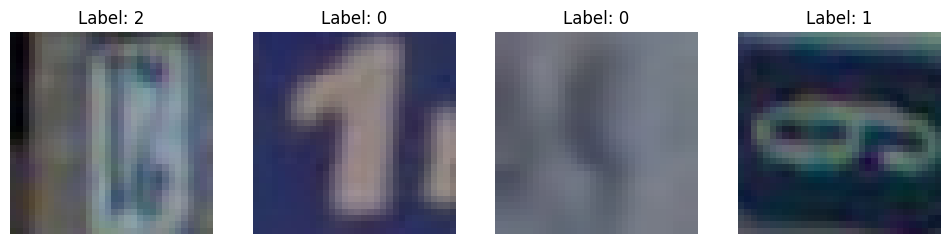

In [86]:
dl = SVHNPretextDataModule(".", 32)
dl.setup(None)

# TODO : Plot


!pip install matplotlib

import matplotlib.pyplot as plt

# Get a batch of data from the dataloader
batch = next(iter(dl.train_dataloader()))
images, labels = batch

# Assuming 'images' is a tensor of shape (batch_size, channels, height, width)
# Choose the number of images to display
num_images_to_display = 4  # Example: display 4 images

# Create a figure and axes
fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 4))

# Loop through the selected images and display them
for i in range(num_images_to_display):
    # Permute the dimensions to (height, width, channels) for Matplotlib
    image = images[i].permute(1, 2, 0)

    # Display the image
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")  # Turn off axis ticks and labels

# Show the plot
plt.show()

We now define our LightningModule for the pretext task learning. It is important to note that the **encoder architecture must be the same** as in the final task of digit classification. Although we are free to choose the classifier, we will reuse the SVHNClassifier class.

In [87]:
class SVHNPretextModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # TODO : Init your Model
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 4) # Output for rotation prediction (0, 90, 180, 270)
        )

        self.classifier = nn.Sequential(
            nn.Linear(4, 128), # Change input features to 4 to match encoder output
            nn.ReLU(),
            nn.Linear(128, 10) # Output for 10 SVHN classes
        )

    def forward(self,x):
        # TODO.
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), 1e-2)
        return optimizer

    def training_step(self, batch, batch_idx):
        # TODO : Define your Training Step
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean() # Calculate accuracy
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        # TODO : Define your Validation Step
        # We will also be logging our val accuracy here.
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean() # Calculate accuracy
        self.log('val_loss', loss)
        self.log('val_acc', acc)

#### Training

Train your Model

In [88]:
# TODO : Train
pretext_model = SVHNPretextModel()
dm = SVHNDataModule(data_dir='data/', batch_size=32)
logger=WandbLogger(name='SVHN_rot',project='SVHN_pretext')
trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     max_epochs=7,
                     default_root_dir="SVHN_pretext",
                     val_check_interval=0.25,
                     logger=logger)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [89]:
trainer.fit(pretext_model, dm)
wandb.finish()

Using downloaded and verified file: data/train_32x32.mat


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | encoder    | Sequential | 1.1 M  | train
1 | classifier | Sequential | 1.9 K  | train
--------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.585     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇▇████
train_acc,▁█
train_loss,█▁
trainer/global_step,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val_acc,▁▂██████▁▁▁█████████████████
val_loss,█▁▃▂▂▄▂▂▂▂▂▁▂▂▂▁▁▁▁▁▂▂▂▁▁▁▁▁
epoch,6
train_acc,0.25
train_loss,2.19177
trainer/global_step,123
val_acc,0.17486


### ii - Classification fine-tunning

We will now reuse the learnt pretext task encoder as an initialization for digit classification.

#### Training

We will load the checkpoint of the pretext task encoder, and use its weights as an initialization of our final classification encoder. There are many ways to perform fine-tunning from a pretrained network; here we choose to freeze all the weights of the encoder and only train the classifier on the labeled data.

In [90]:
# Reload the best pretext model.
# Check that the following path matches your best pretext task training checkpoint directory.
pretext_checkpoint_dir = "SVHN_pretext/lightning_logs/version_0/checkpoints"
# Get a list of all checkpoint files
ckpt_files = glob.glob(os.path.join(CONTENT_DIR, pretext_checkpoint_dir, "*.ckpt"))

# Check if any checkpoint files were found
if ckpt_files:
    best_ckpt = ckpt_files[0]  # Select the first checkpoint file
    print("Loading checkpoint from", best_ckpt)
    pretext_model = SVHNPretextModel.load_from_checkpoint(best_ckpt)
    pretext_model.freeze()
else:
    print(f"Error: No checkpoint files found in {os.path.join(CONTENT_DIR, pretext_checkpoint_dir)}")
    # Handle the case where no checkpoints are found, e.g., exit or raise an exception


'''
# Reload the best pretext model.
# TODO: Check that the following path matches your best pretext task training checkpoint directory.
pretext_checkpoint_dir = "SVHN_pretext/lightning_logs/version_0/checkpoints"
best_ckpt = glob.glob(os.path.join(CONTENT_DIR, pretext_checkpoint_dir, "*.ckpt"))[0]
print("Loading checkpoint from", best_ckpt)
pretext_model = SVHNPretextModel.load_from_checkpoint(best_ckpt)
pretext_model.freeze()
'''
# TODO: Create the SVHN classification model and use the encoder from the pretext model.


model = SVHNClassifier(n_class=10)
dm = SVHNDataModule(data_dir=CONTENT_DIR, batch_size=128)
logger = WandbLogger(name='SVHN_finetune',project='SVHN_classif')
trainer = pl.Trainer(accelerator='gpu',
                     devices=-1,  # Use all available GPUs
                     max_epochs=70,
                     default_root_dir="SVHN_classification",
                     logger=logger)
trainer.fit(model, dm)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Error: No checkpoint files found in /content/SVHN_pretext/lightning_logs/version_0/checkpoints


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Using downloaded and verified file: /content/train_32x32.mat


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | classifier | Sequential | 133 K  | train
--------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.536     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

AttributeError: 'SVHNClassifier' object has no attribute 'encoder'

Pytorch lightning first displays a summary of the training parameters.

* What difference do you observe by comparing it to the training from scratch ?
* Why is it so ?

### Testing

* Test some images from the testing dataset to verify that your model works.

In [ ]:
# TODO : Evaluate your model using the LightningModule test method.
trainer.test(model,dm)
wandb.finish()

* Do you consider the model to be accurate ?
* Has the pretext task pretraining on the unlabeled data helped to improve the performance of the classifier from scratch ?

We note that for longer training times, the benefits of the self-supervised training would be more significant.

# II - Industrial Task 2 : Anomaly Detection on faces

In this last section, we will show an application of pretext tasks for anomaly detection. The main idea is that a model trained to solve a pretext task on some normal data will be less efficient on solving this task on very different data.

In particular we will learn to solve the 90° rotation detection task on the celebA dataset. The celebA dataset contains many images of celebrities which will be our normal face class samples. We have reduced the amount of samples and the size of the images to 64x64.

In [ ]:
# Download and extract CelebA dataset.
!pip install gdown
!gdown --id 1DisQMhb1fnmXGCC-JGqUTu2l7d5E1ihI
celeba_dname = os.path.join(CONTENT_DIR, "CelebA")
celeba_fname = os.path.join(CONTENT_DIR, "celebA_subset.zip")
os.makedirs(celeba_dname, exist_ok=True)
extract_archive(celeba_fname, celeba_dname)

In [ ]:
# Loading the celebA dataset.
class CelebA(Dataset):
    def __init__(self, root, split, **kwargs):
        ds_dname = os.path.join(root, "CelebA")
        if not os.path.exists(ds_dname):
            raise FileNotFoundError(ds_dname)

        self.fnames = glob.glob(os.path.join(ds_dname, {"test": "Test", "train": "Train", "valid": "Eval"}[split], "*.jpg"))

    def __getitem__(self, k):
        fname = self.fnames[k]
        img = Image.open(fname)
        return img

    def __len__(self):
        return len(self.fnames)


* Perform a pretext task training on the rotation detection task with the celebA data.

You should follow the same steps as in the pretext task training on the digit data, as the training is very similar
As usual, you are free to choose the architecture and optimizer

In [ ]:
class CelebAPretextDataModule(pl.LightningDataModule):
    # TODO : Create your DataModule
    # Note that we don't have to manually split the training and validation data as the split='train' and split='valid' are defined for celebA.
    def __init__(self, data_dir, batch_size, shuffle=True):
        self.shuffle = shuffle
        ...

    def train_dataloader(self):
        return DataLoader(..., shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(..., shuffle=self.shuffle)


In [ ]:
class CelebAPretextModel(pl.LightningModule):
    # TODO : Create your LightningModule


In [ ]:
# TODO : Train your model
model = ...
dm = ...
logger = WandbLogger(name='celeba',project='celeba_pretext')
trainer = pl.Trainer(gpus=-1,
                     max_epochs=10,
                     default_root_dir="celeba_pretext",
                     logger=logger )
trainer.fit(model, dm)
wandb.finish()

Now that our model has been trained to solve the pretext task on real faces from celebA data, we expect it to solve the task quite well. More specifically, we can expect our model to be **more accurate on solving the rotation task on faces (normal data) than on other types of data outside faces (anomalies)**.

We can thus construct a very simple anomaly detector by using the softmax score corresponding to the ground-truth as a normality score. The more confident our model is on the ground-truth, the more normal we can consider the input to be.

In [ ]:
def compute_anomaly_score(batch):
    x, y = batch
    # TODO : Compute the softmax scores using the trained CelebAPretextModel.
    soft_scores = ...
    # Take the score corresponding to the ground truth class.
    gt_soft_scores = (soft_scores*F.one_hot(y)).sum(1)
    return gt_soft_scores

We will use the CIFAR-10 dataset as the anomalous data. We now compute the anomaly scores on the normal dataset (celebA) and the anomalies (CIFAR-10).

In [ ]:
normal_dm = CelebAPretextDataModule(..., shuffle=False)
normal_dm.setup(None)

model.eval()

with torch.no_grad():
    normal_scores = []
    for batch in dm.test_dataloader():
        normal_scores.extend(compute_anomaly_score(batch).cpu().numpy())

    anomaly_scores = []
    for batch in DataLoader(CIFAR10('.', train=False, download=True, transform=transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])),
                            batch_size=32, shuffle=False):
        anomaly_scores.extend(compute_anomaly_score(batch).cpu().numpy())

normal_scores = np.array(normal_scores).reshape((-1, 4)).mean(1)
anomaly_scores = np.array(anomaly_scores).reshape((-1, 4)).mean(1)

**TODO**: Plot the ROC curve and print the AUC of the anomaly detector.

* What can you say ?